In [3]:
import json
import os
import re
from copy import deepcopy
import random
import mysql.connector
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
%load_ext autoreload
%autoreload 2

download_dir = '/home/yuan/data/IEDB'
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')
print(data_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/yuan/bio/ml_epitope/data


## export epitopes in mysql to json files

In [111]:
# step 1: from csv downloaded from IEDB
epitopes, n = {}, 0

print('read csv...')
df = pd.read_csv(os.path.join(download_dir, 'epitope_full_v3.zip'), header=[0, 1])
df = df[(df[('Epitope', 'Modified Residue(s)')].isna()) & (~df[('Epitope', 'Starting Position')].isna())]

print('retrieve epitopes...')
for i, row in df.iterrows():
    epitope = {
        'id': str(row[('Epitope ID', 'IEDB IRI')].replace('http://www.iedb.org/epitope/', '')),
        'type': str(row[('Epitope', 'Object Type')]),
        'seq': str(row[('Epitope', 'Name')]),
        'start': int(row[('Epitope', 'Starting Position')]),
        'end': int(row[('Epitope', 'Ending Position')]),
    }
    parent_url = str(row[('Epitope', 'Molecule Parent IRI')])
    parent_acc = parent_url.replace('http://www.uniprot.org/uniprot/','')
    if parent_acc not in epitopes:
        epitopes[parent_acc]= {
            'parent_url': parent_url,
            'epitopes': [],
        }
    epitopes[parent_acc]['epitopes'].append(epitope)
    n += 1
print(f"proteins={len(epitopes)}, epitopes={n}.")

# save epitopes to json
outfile = os.path.join(data_dir, 'epitopes_1.json')
with open(outfile, 'w') as f:
    json.dump(epitopes, f, indent=4, sort_keys=True)
print(f"save data into {outfile}")

read csv...


/tmp/ipykernel_48774/110011376.py:4: DtypeWarning: Columns (3,4,7,8,17,18,19,22,23,24,25,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(download_dir, 'epitope_full_v3.zip'), header=[0, 1])


retrieve epitopes...
proteins=70652, epitopes=1798795.
save data into /home/yuan/bio/ml_epitope/data/epitopes_1.json


In [137]:
# step 2: integrated proteins from UniProt
# wget -c ftp://ftp.uniprot.org/pub/databases/uniprot/knowledgebase/complete/uniprot_sprot.dat.gz
import gzip
from Bio import SwissProt

with open(os.path.join(data_dir, 'epitopes_1.json'), 'r') as f:
    epitopes = json.load(f)

n = 0
infile = '/home/yuan/data/UniProt/uniprot_sprot.dat.gz'
with gzip.open(infile, 'rt') as f:
    for record in SwissProt.parse(f):
        for acc in record.accessions:
            if acc in epitopes:
                rec = {
                    'accession': acc,
                    'description': record.description, 
                    'gene_name': record.gene_name,
                    'pro_seq': record.sequence,
                }
                epitopes[acc].update(rec)
                n += 1
                if n % 1000 == 0:
                    print(n, end=',')
print(f"{n} out of {len(epitopes)} proteins are updated.")

# save epitopes to json
outfile = os.path.join(data_dir, 'epitopes_2.json')
with open(outfile, 'w') as f:
    json.dump(epitopes, f, indent=4, sort_keys=True)
print(f"save data into {outfile}")

1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000,21000,22000,23000,24000,25000,26000,27000,28000,29000,30000,31000,32000,33000,34000,35000,36000,37000,38000,39000,40000,41000,41805 out of 70652 proteins are updated.
save data into /home/yuan/bio/ml_epitope/data/epitopes_2.json


In [138]:
# step 3: integrated proteins from UniProt-Trembl
# wget -c ftp://ftp.uniprot.org/pub/databases/uniprot/knowledgebase/complete/uniprot_trembl.dat.gz
import gzip
from Bio import SwissProt

pool = set()
with open(os.path.join(data_dir, 'epitopes_2.json'), 'r') as f:
    epitopes = json.load(f)
    for acc in epitopes:
        if 'pro_seq' not in epitopes[acc]:
            pool.add(acc)
print(f"check unknown {len(pool)} out of {len(epitopes)} proteins...")
t = len(pool)

n = 0
# uniprot_trembl.dat.gz include more accessions
infile = '/home/yuan/data/UniProt/uniprot_trembl.dat.gz'
try:
    with gzip.open(infile, 'rt') as f:
        for record in SwissProt.parse(f):
            for acc in record.accessions:
                if acc in pool:
                    rec = {
                        'accession': acc,
                        'description': record.description, 
                        'gene_name': record.gene_name,
                        'pro_seq': record.sequence,
                    }
                    epitopes[acc].update(rec)
                    pool.remove(acc)
                    n += 1
                    if n % 1000 == 0:
                        print(n, end=',')
except Exception as e:
    print(e)
print(f"{n} out of {t} proteins are updated.")

# save epitopes to json
outfile = os.path.join(data_dir, 'epitopes_3.json')
with open(outfile, 'w') as f:
    json.dump(epitopes, f, indent=4, sort_keys=True)
print(f"save data into {outfile}")

check unknown 28858 out of 70652 proteins...
1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000,21000,22000,23000,24000,25000,26000,26954 out of 28858 proteins are updated.
save data into /home/yuan/bio/ml_epitope/data/epitopes_3.json


In [10]:
# step 4: integrate data from database
def sql_data(query):
    config = {
        'host': 'localhost',
        'user': 'admin',
        'password': 'strong_password',
        'database': 'IEDB'
    }
    try:
        connection = mysql.connector.connect(**config)
        cursor = connection.cursor(dictionary=True)

        cursor.execute(query)
        rows = cursor.fetchall()
        # rows = [{k: float(v) if isinstance(v, decimal.Decimal) else v 
        #              for k, v in row.items()} for row in rows]
        return rows        
    except Exception as e:
        print(f"Error: {e}")
    finally:
        if 'connection' in locals() and connection.is_connected():
            cursor.close()
            connection.close()

query = """
    SELECT c.accession, 
        GROUP_CONCAT(distinct c.database SEPARATOR ';') AS db,
        GROUP_CONCAT(distinct c.name SEPARATOR ';') AS gene_name,
        GROUP_CONCAT(distinct c.sequence SEPARATOR ';') AS pro_seq
    FROM source c
    WHERE sequence is NOT NULL
    GROUP BY c.accession
"""
rows = sql_data(query)

In [11]:
# integrate proteins

pool = set()
with open(os.path.join(data_dir, 'epitopes_3.json'), 'r') as f:
    epitopes = json.load(f)
    for acc in epitopes:
        if 'pro_seq' not in epitopes[acc]:
            pool.add(acc)
print(f"check unknown {len(pool)} out of {len(epitopes)} proteins...")
t = len(pool)

n = 0
for record in rows:
    acc = record['accession']
    if acc in pool:
        epitopes[acc].update(record)
        # print(acc, end=',')
        n += 1
print(f"{n} out of {t} proteins are added.")

# save epitopes to json
outfile = os.path.join(data_dir, 'epitopes_4.json')
with open(outfile, 'w') as f:
    json.dump(epitopes, f, indent=4, sort_keys=True)
print(f"save data into {outfile}")

check unknown 1904 out of 70652 proteins...
192 out of 1904 proteins are added.
save data into /home/yuan/bio/ml_epitope/data/epitopes_4.json


## distribution

In [14]:
from utils import Utils

with open('/home/yuan/bio/ml_epitope/data/epitopes_4.json', 'r') as f:
    data=json.load(f)


protein_len, epitope_len, pro_epi = [], [], []
num_pro, num_epi = 0, 0
for acc in data:
    num_pro += 1
    if 'pro_seq' in data[acc]:
        pro_len = len(data[acc]['pro_seq'])
        protein_len.append(pro_len)
    epi_per = len(data[acc]['epitopes'])
    num_epi += epi_per
    pro_epi.append(epi_per)
    for item in data[acc]['epitopes']:
        epi_len = len(item['seq'])
        epitope_len.append(epi_len)
print(f"Number of proteins = {num_pro}")
print(f"Number of epitopes = {num_epi}")

Number of proteins = 70652
Number of epitopes = 1798795


In [19]:
protein_len

[287,
 525,
 297,
 64,
 418,
 75,
 136,
 59,
 6781,
 279,
 1396,
 510,
 311,
 266,
 3240,
 1015,
 140,
 1236,
 2467,
 519,
 245,
 153,
 509,
 494,
 71,
 925,
 113,
 117,
 120,
 119,
 116,
 99,
 119,
 324,
 116,
 117,
 115,
 117,
 117,
 117,
 117,
 117,
 118,
 119,
 117,
 117,
 98,
 117,
 117,
 98,
 98,
 117,
 117,
 117,
 119,
 115,
 115,
 4707,
 116,
 117,
 119,
 122,
 120,
 117,
 118,
 117,
 123,
 115,
 118,
 115,
 115,
 115,
 115,
 115,
 114,
 111,
 115,
 118,
 117,
 120,
 120,
 117,
 117,
 120,
 117,
 113,
 132,
 112,
 113,
 121,
 154,
 20,
 346,
 365,
 164,
 576,
 117,
 117,
 119,
 116,
 438,
 433,
 226,
 443,
 293,
 196,
 573,
 1211,
 237,
 2841,
 869,
 766,
 407,
 304,
 153,
 492,
 163,
 2314,
 1261,
 3271,
 74,
 4024,
 309,
 397,
 556,
 490,
 4602,
 367,
 508,
 1232,
 504,
 529,
 123,
 118,
 115,
 117,
 944,
 112,
 109,
 112,
 109,
 142,
 597,
 185,
 250,
 160,
 102,
 108,
 660,
 511,
 135,
 555,
 93,
 103,
 874,
 3843,
 224,
 522,
 286,
 82,
 115,
 168,
 667,
 1679,
 2988,
 302

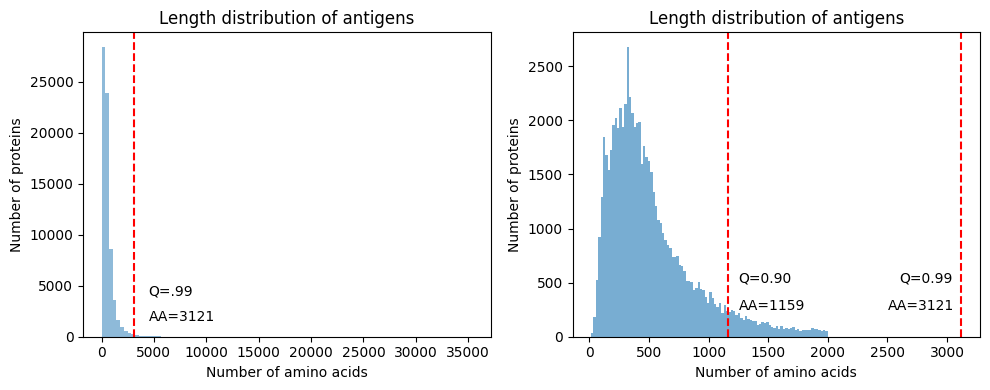

In [46]:
fig, ax = plt.subplots(1,2, figsize=(10, 4), layout='tight')

q99 = round(np.quantile(protein_len, .99))
q90 = round(np.quantile(protein_len, .9))

i=0
median_len = np.median(protein_len)
ax[i].hist(protein_len, bins=100, histtype='bar', alpha=.5)
ax[i].axvline(x=q99, c='red', linestyle='--')
ax[i].text(4500, 4000, s='Q=.99')
ax[i].text(4500, 1500, s=f'AA={q99}')
ax[i].set_title('Length distribution of antigens')
ax[i].set_xlabel('Number of amino acids')
ax[i].set_ylabel('Number of proteins')

mode_protein = np.array(protein_len)
mode_protein = mode_protein[mode_protein<2000]
i = 1
ax[i].hist(mode_protein, bins=100, histtype='bar', alpha=.6)
ax[i].axvline(x=q90, c='red', linestyle='--')
ax[i].text(1250, 500, s='Q=0.90')
ax[i].text(1250, 250, s=f'AA={q90}')
ax[i].axvline(x=q99, c='red', linestyle='--')
ax[i].text(2600, 500, s='Q=0.99')
ax[i].text(2500, 250, s=f'AA={q99}')
ax[i].set_title('Length distribution of antigens')
ax[i].set_xlabel('Number of amino acids')
ax[i].set_ylabel('Number of proteins')

plt.show()

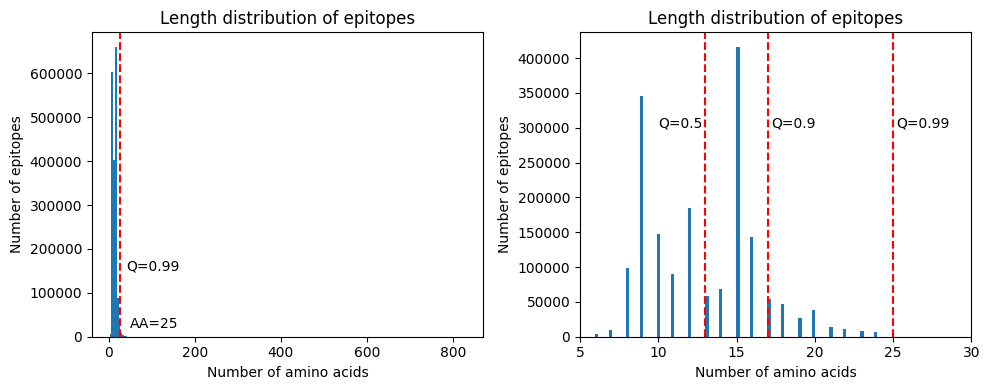

In [48]:
fig, ax = plt.subplots(1,2, figsize=(10, 4), layout='tight')

q99 = round(np.quantile(epitope_len, q=.99))
q90 = round(np.quantile(epitope_len, q=.9))
q50 = round(np.quantile(epitope_len, q=.5))

i = 0
ax[i].hist(epitope_len, bins=200)
ax[i].axvline(x=q99, c='red', linestyle='--')
ax[i].text(40, 150000, s='Q=0.99')
ax[i].text(50, 20000, s=f'AA={q99}')
ax[i].set_title('Length distribution of epitopes')
ax[i].set_xlabel('Number of amino acids')
ax[i].set_ylabel('Number of epitopes')

i = 1
mode_epitope = np.array(epitope_len)
mode_epitope = mode_epitope[mode_epitope < q99]
ax[i].hist(mode_epitope, bins=100)
ax[i].set_xlim(5, 30)
ax[i].axvline(x=q50, c='red', linestyle='--')
ax[i].text(10, 300000, s='Q=0.5')
ax[i].axvline(x=q90, c='red', linestyle='--')
ax[i].text(17.2, 300000, s='Q=0.9')
ax[i].axvline(x=q99, c='red', linestyle='--')
ax[i].text(25.2, 300000, s='Q=0.99')
ax[i].set_title('Length distribution of epitopes')
ax[i].set_xlabel('Number of amino acids')
ax[i].set_ylabel('Number of epitopes')
plt.show()

327 49 3


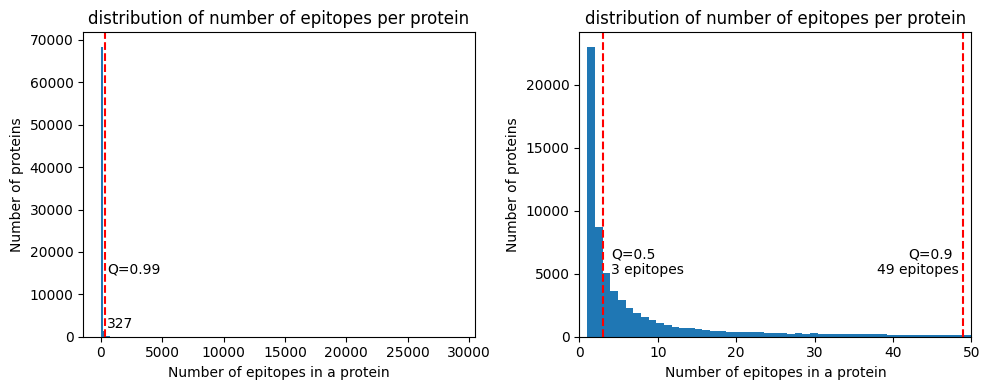

In [91]:
fig, ax = plt.subplots(1,2, figsize=(10, 4), layout='tight')

q99 = round(np.quantile(pro_epi, q=.99))
q90 = round(np.quantile(pro_epi, q=.9))
q50 = round(np.quantile(pro_epi, q=.5))
print(q99, q90, q50)

i = 0
ax[i].hist(pro_epi, bins=200)
ax[i].axvline(x=q99, c='red', linestyle='--')
ax[i].text(500, 15000, s='Q=0.99')
ax[i].text(500, 2000, s=q99)
ax[i].set_title('distribution of number of epitopes per protein')
ax[i].set_xlabel('Number of epitopes in a protein')
ax[i].set_ylabel('Number of proteins')

i = 1
mode_epitope = np.array(pro_epi)
mode_epitope = mode_epitope[mode_epitope <= 50]
ax[i].hist(mode_epitope, bins=50)
ax[i].set_xlim(0,50)
ax[i].set_title('distribution of number of epitopes per protein')
ax[i].set_xlabel('Number of epitopes in a protein')
ax[i].set_ylabel('Number of proteins')
# 
ax[i].axvline(x=q50, c='red', linestyle='--')
ax[i].text(4, 6200, s='Q=0.5')
ax[i].text(4, 5000, s=f'{q50} epitopes')
#
ax[i].axvline(x=q90, c='red', linestyle='--')
ax[i].text(42, 6200, s='Q=0.9')
ax[i].text(38, 5000, s=f'{q90} epitopes')

plt.show()

## deprecated process

In [ ]:
# 
USE IEDB;

<!-- test query -->
SELECT a.curated_epitope_id, a.e_name, a.e_region_domain_flag,
    b.object_id, b.starting_position, b.ending_position, b.mol1_seq, b.mol1_modified_seq, b.mol2_modified_seq,
    c.accession, c.database, c.name, c.sequence
FROM curated_epitope a, object b, source c
WHERE a.e_object_id = b.object_id
    AND b.mol2_source_id = c.source_id
    AND b.starting_position is NOT NULL
    AND c.sequence is NOT NULL
LIMIT 10;

# 
WITH selected_source AS(
    SELECT c.accession, c.database, c.name, c.sequence
    FROM source c
    WHERE accession LIKE "A%"
        AND sequence is NOT NULL
)
SELECT a.curated_epitope_id, a.e_region_domain_flag,
    b.object_id, b.starting_position, b.ending_position, b.mol1_seq,
    c.accession, c.database, c.name, c.sequence
FROM curated_epitope a, object b, selected_source c
WHERE a.e_object_id = b.object_id
    AND b.mol2_source_id = c.source_id
    AND b.starting_position is NOT NULL;

<!-- create a view  -->
CREATE VIEW view_epitope AS
SELECT a.curated_epitope_id, a.e_name, a.e_region_domain_flag,
    b.object_id, b.cell_type, b.starting_position, b.ending_position,
    b.mol1_seq, b.mol1_modified_seq, b.mol2_modified_seq,
    c.accession, c.database, c.name, c.sequence
FROM curated_epitope a, object b, source c
WHERE a.e_object_id = b.object_id
    AND b.mol2_source_id = c.source_id
    AND b.starting_position is NOT NULL
    AND c.sequence is NOT NULL;

In [ ]:
import json
import decimal
import mysql.connector

def export_large_table(outdir, prefix:str):
    config = {
        'host': 'localhost',
        'user': 'admin',
        'password': 'strong_password',
        'database': 'IEDB'
    }
    try:
        connection = mysql.connector.connect(**config)
        cursor = connection.cursor(dictionary=True)

        query = "SELECT * FROM view_epitope WHERE SUBSTRING(accession, 1, 1) = \'" + prefix + "\'"
        print(query)
        cursor.execute(query)
        rows = cursor.fetchall()
        rows = [{k: float(v) if isinstance(v, decimal.Decimal) else v 
                     for k, v in row.items()} for row in rows]
        
        outfile = os.path.join(outdir, f'epitope_{prefix}.json')
        print(outfile)
        with open(outfile, 'w') as f:
            json.dump(rows, f, indent=4)
    except Exception as e:
        print(f"Error: {e}")
    finally:
        if 'connection' in locals() and connection.is_connected():
            cursor.close()
            connection.close()

json_dir = '/home/yuan/data/omics_data/epitope/mysql'
pool = [chr(i) for i in list(range(48,58)) + list(range(65, 91))]
print(pool)
for prefix in pool[10:]:
    export_large_table(json_dir, prefix)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
SELECT * FROM view_epitope WHERE SUBSTRING(accession, 1, 1) = 'A'


range(0, 10)

### count data by source

In [ ]:
# counts antigens with epitopes
db_params = {
    'host': "localhost",
    'user': "admin",
    'passwd': "strong_password",
    'database': 'IEDB',
}
conn = mysql.connector.connect(**db_params)
cursor = conn.cursor()
res = cursor.execute("""
    SELECT c.database, COUNT(DISTINCT c.accession) AS proteins, COUNT(a.curated_epitope_id) AS epitopes
    FROM curated_epitope a, object b, source c
    WHERE a.e_object_id = b.object_id
        AND b.mol2_source_id = c.source_id
        AND b.starting_position is NOT NULL
    GROUP BY c.database
""")
print(res)
conn.close()

In [ ]:
res